# Description
Uses Markov Chain Monte Carlo to fit $b1$ and $\beta$ of the linear model. The MCMC package Zeus is used (documentation (https://zeus-mcmc.readthedocs.io/en/latest/index.html and useful cookbook https://zeus-mcmc.readthedocs.io/en/latest/notebooks/datafit.html). $\chi^2$ is the log-likelihood function and found as described in `Fitting_b1_different_kmax.ipynb`. By Bayes' theorem, the posterior distribution is given (up to a normalization constant) by the product of the likelihood function and the prior distribution. Consequently, log-posterior is just the sum of the log-likelihood and the log-prior.

Each walker explores the parameter space and produced a set of parameter values sampled from the posterior distribution. The number of walkers must be even and should be between 2 and 4 times the number of parameters (ndim). The starting point in parameter space of each walker is specified by `start`. From there, `nsteps` along the Markov Chain are taken.

To get access the sampled parameters, use `sampler.get_chain()`. Without any arguments this gives an array of shape `(nsteps, nwalkers, ndim)`. Set `flat=True` to get flat array. Can also specify that the first N samples of each walker (burn-in phase) should be discarded via `discard=N`. This is done before the flattening. Can also thin out chains by some factor via the argument `thin`.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import bayes_mvs

import inv_cov_funcs as icf
import classylss
import fitsio
import zeus 
from nbodykit.lab import *
from nbodykit import style, setup_logging
#setup_logging()
plt.style.use(style.notebook)

In [3]:
LOS = [0,0,1]
redshift = 0
BoxSize = 2000
cosmo_paras = classylss.load_ini('/home/jwack/main/Planck18_LCDM.ini')
cosmo = cosmology.cosmology.Cosmology.from_dict(cosmo_paras)
Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu')
sigma8_lin = Plin.sigma8
sigma8_true = 0.8111 
f0_true = cosmo.scale_independent_growth_rate(redshift)

dk = 0.01
kmax = 0.05 # due to BoxSize, last bin with nonz zero Fourier mode is k = 0.343. Hence, kmax<0.343.
ells = [0,2]

/home/jwack/.conda/envs/nbodykit-env/lib/python3.8/site-packages/nbodykit/cosmology/cosmology.py:427: UserWarning: Class did not read input parameter(s): sigma_8, w0_fld, wa_fld
  self.engine = ClassEngine(pars)
/home/jwack/.conda/envs/nbodykit-env/lib/python3.8/site-packages/nbodykit/cosmology/cosmology.py:427: UserWarning: Class did not read input parameter(s): sigma_8
  self.engine = ClassEngine(pars)


In [4]:
# load computed power spectra to deduce multipoles in each bin and P(k,mu) from data
k_full, shotnoise, n_ptile, Pk_ells_full, mus, Pkmus_full = icf.load_power_data('/home/jwack/main/fit_linear_model_in_density_bins/', 
                                                               ells, get_data_Pkmus=True)
# slice down arrays of k and multipoles
mask = k_full <= kmax
mask[0] = False 
k = k_full[mask]
Pk_ells = Pk_ells_full[:,:,mask]
Pkmus = Pkmus_full[:,mask,:] 

### Note on choice of prior
For uniform prior: When parameter in range, set prior to 1 (log prior to 0) and when outside range set to 0 (log prior to -inf)
Could have used more informed prior such as a normal one: 
```
    b1_mu, b1_sig = 1, 0.5
    lp_b1 = -0.5*((b1-b1_mu)/b1_sig)**2 #if beta > 0 else: -np.inf 
    beta_mu, beta_sig = 1.1, 1
    lp_beta = -0.5*((beta-beta_mu)/beta_sig)**2 if beta > 0 else -np.inf 
```
Not recommended to use with static mean and variance as b1, beta change significantly across the density bins.

In [5]:
def logprior(theta):
    ''' The natural logarithm of the prior probability. Assume parameters independent such that log priors add.
    Note that normalization is irrelevant for MCMC.'''
    lp = 0.
    b1, beta = theta
    # choose uniform priors for both parameters. 
    b1_min, b1_max = 0, 3
    beta_min, beta_max = 0, 3
    
    lp_b1 = 0. if b1_min < b1 < b1_max else -np.inf
    lp_beta = 0. if beta_min < beta < beta_max else -np.inf

    return lp_b1 + lp_beta


def loglike(theta, data_multipoles, k, C_inv):
    '''Return logarithm of likelihood i.e. -0.5*chi2.
    data_multipoles must be an array of shape (len(ells), len(k)). theta is parameter vector: [b1, beta].
    Due to hard coding multipoles, only works for ells = [0,2] and purely linear Kaiser theory. Alternative described in 
    minimizing chi2 and ABC fitting notebooks.'''
    b1, beta = theta
    ells = [0,2]
    # make model vector
    model_multipoles = np.empty((len(ells), len(k)))
    model_multipoles[0] = (1 + 2/3*beta + 1/5*beta**2) * b1**2 * Plin(k)
    model_multipoles[1] = (4/3*beta + 4/7*beta**2) * b1**2 * Plin(k)
        
    D_M = (data_multipoles - model_multipoles).flatten()
    
    return -0.5*D_M@(C_inv @ D_M)


def logpost(theta, data_multipoles, k, C_inv):
    '''Returns the logarithm of the posterior. By Bayes' theorem, this is just the sum of the log prior and log likelihood (up 
    to a irrelavant constant).
    ''' 
    return logprior(theta) + loglike(theta, data_multipoles, k, C_inv)

In [7]:
# arrays full of NaN. When not enough candidates accepted, NaN remains and percentile will not be plotted
b1_fits, beta_fits = np.full(n_ptile, np.nan), np.full(n_ptile, np.nan) # mean of accepted parameters
b1_cred, beta_cred = np.full((n_ptile,2), np.nan), np.full((n_ptile,2), np.nan) # 3 sigma credibility interval
reduced_chi2 = np.full(n_ptile, np.nan) # reduced chi at mean of accepted parameters 

ndim = 2
nwalkers = 6 
nsteps = 1000
chains = [] # keep track of all unprocessed chains to have option to plot individually later 

start = 0.5 + np.random.random((nwalkers, ndim)) # initial positions: randomly choosen between 0.5 and 1.5 

for i in range(n_ptile):
    t1 = time.time()
    ### choose between analytic or mock covariance matrix ###
#     C_inv = icf.gaussian_cov_mat_inv(k, ells, BoxSize, shotnoise, dk, Pkmus[i], mus) # analytic with data P(k,mu)
    cov_mat = np.loadtxt('/home/jwack/main/bruteforce_covmat/covariance_matricies/cov_ptile_%d.txt'%i)
    C_inv = icf.mock_cov_mat_inv(cov_mat, k_full, kmax) # mock 
    
    # Initialise the sampler. To see progress of sampling set verbose=True
    sampler = zeus.EnsembleSampler(nwalkers, ndim, logpost, maxiter=1e5, verbose=True, args=[Pk_ells[i], k, C_inv]) 
    sampler.run_mcmc(start, nsteps) # Run sampling
    sampler.summary # Print summary diagnostics
    
    chains.append(sampler.get_chain())
    chain = sampler.get_chain(flat=True, discard=nsteps//2)
    b1_stats, _, _ = bayes_mvs(chain[:,0], alpha=0.997) 
    beta_stats, _, _ = bayes_mvs(chain[:,1], alpha=0.997)
    b1_fits[i], b1_cred[i][0], b1_cred[i][1] = b1_stats[0], b1_stats[1][0], b1_stats[1][1]
    beta_fits[i], beta_cred[i][0], beta_cred[i][1] = beta_stats[0], beta_stats[1][0], beta_stats[1][1]
    reduced_chi2[i] = -2*loglike([b1_fits[i], beta_fits[i]], Pk_ells[i], k, C_inv) / (2*len(k)-2)
    t2 = time.time()
    print('Fitted %d-th percentile in %.2f sec'%(i+1,t2-t1))

Initialising ensemble of 6 walkers...

Sampling progress :  51%|██████████████████████████████▊                             | 514/1000 [00:08<00:06, 70.68it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 66.03it/s]
Summary
-------
Number of Generations: 1000
Number of Parameters: 2
Number of Walkers: 6
Number of Tuning Generations: 40
Scale Factor: 0.215356
Mean Integrated Autocorrelation Time: 5.83
Effective Sample Size: 1029.4
Number of Log Probability Evaluations: 60302
Effective Samples per Log Probability Evaluation: 0.017071
Initialising ensemble of 6 walkers...


Fitted 1-th percentile in 15.26 sec



Sampling progress :  88%|████████████████████████████████████████████████████       | 882/1000 [00:06<00:00, 128.92it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.15it/s]
Summary
-------
Number of Generations: 1000
Number of Parameters: 2
Number of Walkers: 6
Number of Tuning Generations: 35
Scale Factor: 1.299184
Mean Integrated Autocorrelation Time: 3.67
Effective Sample Size: 1633.1
Number of Log Probability Evaluations: 31255
Effective Samples per Log Probability Evaluation: 0.052251
Initialising ensemble of 6 walkers...


Fitted 2-th percentile in 7.94 sec



Sampling progress :  87%|███████████████████████████████████████████████████▍       | 871/1000 [00:06<00:01, 127.67it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.06it/s]
Summary
-------
Number of Generations: 1000
Number of Parameters: 2
Number of Walkers: 6
Number of Tuning Generations: 37
Scale Factor: 1.020463
Mean Integrated Autocorrelation Time: 3.37
Effective Sample Size: 1780.13
Number of Log Probability Evaluations: 32243
Effective Samples per Log Probability Evaluation: 0.05521
Initialising ensemble of 6 walkers...


Fitted 3-th percentile in 8.08 sec



Sampling progress :  86%|██████████████████████████████████████████████████▊        | 862/1000 [00:06<00:01, 126.96it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.66it/s]
Summary
-------
Number of Generations: 1000
Number of Parameters: 2
Number of Walkers: 6
Number of Tuning Generations: 40
Scale Factor: 0.897964
Mean Integrated Autocorrelation Time: 3.07
Effective Sample Size: 1951.99
Number of Log Probability Evaluations: 32498
Effective Samples per Log Probability Evaluation: 0.060065
Initialising ensemble of 6 walkers...


Fitted 4-th percentile in 8.16 sec



Sampling progress :  78%|██████████████████████████████████████████████▎            | 785/1000 [00:07<00:01, 113.38it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.32it/s]
Summary
-------
Number of Generations: 1000
Number of Parameters: 2
Number of Walkers: 6
Number of Tuning Generations: 39
Scale Factor: 0.600538
Mean Integrated Autocorrelation Time: 3.42
Effective Sample Size: 1755.49
Number of Log Probability Evaluations: 35885
Effective Samples per Log Probability Evaluation: 0.04892
Initialising ensemble of 6 walkers...


Fitted 5-th percentile in 8.98 sec



Sampling progress :  86%|██████████████████████████████████████████████████▌        | 857/1000 [00:06<00:01, 124.94it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.70it/s]
Summary
-------
Number of Generations: 1000
Number of Parameters: 2
Number of Walkers: 6
Number of Tuning Generations: 41
Scale Factor: 0.938642
Mean Integrated Autocorrelation Time: 3.49
Effective Sample Size: 1717.34
Number of Log Probability Evaluations: 32532
Effective Samples per Log Probability Evaluation: 0.052789
Initialising ensemble of 6 walkers...


Fitted 6-th percentile in 8.22 sec



Sampling progress :  88%|████████████████████████████████████████████████████▏      | 885/1000 [00:06<00:00, 126.69it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.09it/s]
Summary
-------
Number of Generations: 1000
Number of Parameters: 2
Number of Walkers: 6
Number of Tuning Generations: 24
Scale Factor: 1.263741
Mean Integrated Autocorrelation Time: 3.35
Effective Sample Size: 1789.35
Number of Log Probability Evaluations: 31525
Effective Samples per Log Probability Evaluation: 0.05676
Initialising ensemble of 6 walkers...


Fitted 7-th percentile in 7.94 sec



Sampling progress :  88%|████████████████████████████████████████████████████▏      | 884/1000 [00:06<00:00, 131.58it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.62it/s]
Summary
-------
Number of Generations: 1000
Number of Parameters: 2
Number of Walkers: 6
Number of Tuning Generations: 48
Scale Factor: 1.582873
Mean Integrated Autocorrelation Time: 2.81
Effective Sample Size: 2132.11
Number of Log Probability Evaluations: 31353
Effective Samples per Log Probability Evaluation: 0.068003
Initialising ensemble of 6 walkers...


Fitted 8-th percentile in 7.97 sec



Sampling progress :  87%|███████████████████████████████████████████████████        | 866/1000 [00:06<00:01, 128.63it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.77it/s]
Summary
-------
Number of Generations: 1000
Number of Parameters: 2
Number of Walkers: 6
Number of Tuning Generations: 44
Scale Factor: 1.079181
Mean Integrated Autocorrelation Time: 3.66
Effective Sample Size: 1637.94
Number of Log Probability Evaluations: 31570
Effective Samples per Log Probability Evaluation: 0.051883
Initialising ensemble of 6 walkers...


Fitted 9-th percentile in 8.03 sec



Sampling progress :  85%|██████████████████████████████████████████████████         | 849/1000 [00:06<00:01, 123.41it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.97it/s]
Summary
-------
Number of Generations: 1000
Number of Parameters: 2
Number of Walkers: 6
Number of Tuning Generations: 36
Scale Factor: 0.886611
Mean Integrated Autocorrelation Time: 3.17
Effective Sample Size: 1890.18
Number of Log Probability Evaluations: 32845
Effective Samples per Log Probability Evaluation: 0.057548


Fitted 10-th percentile in 8.28 sec


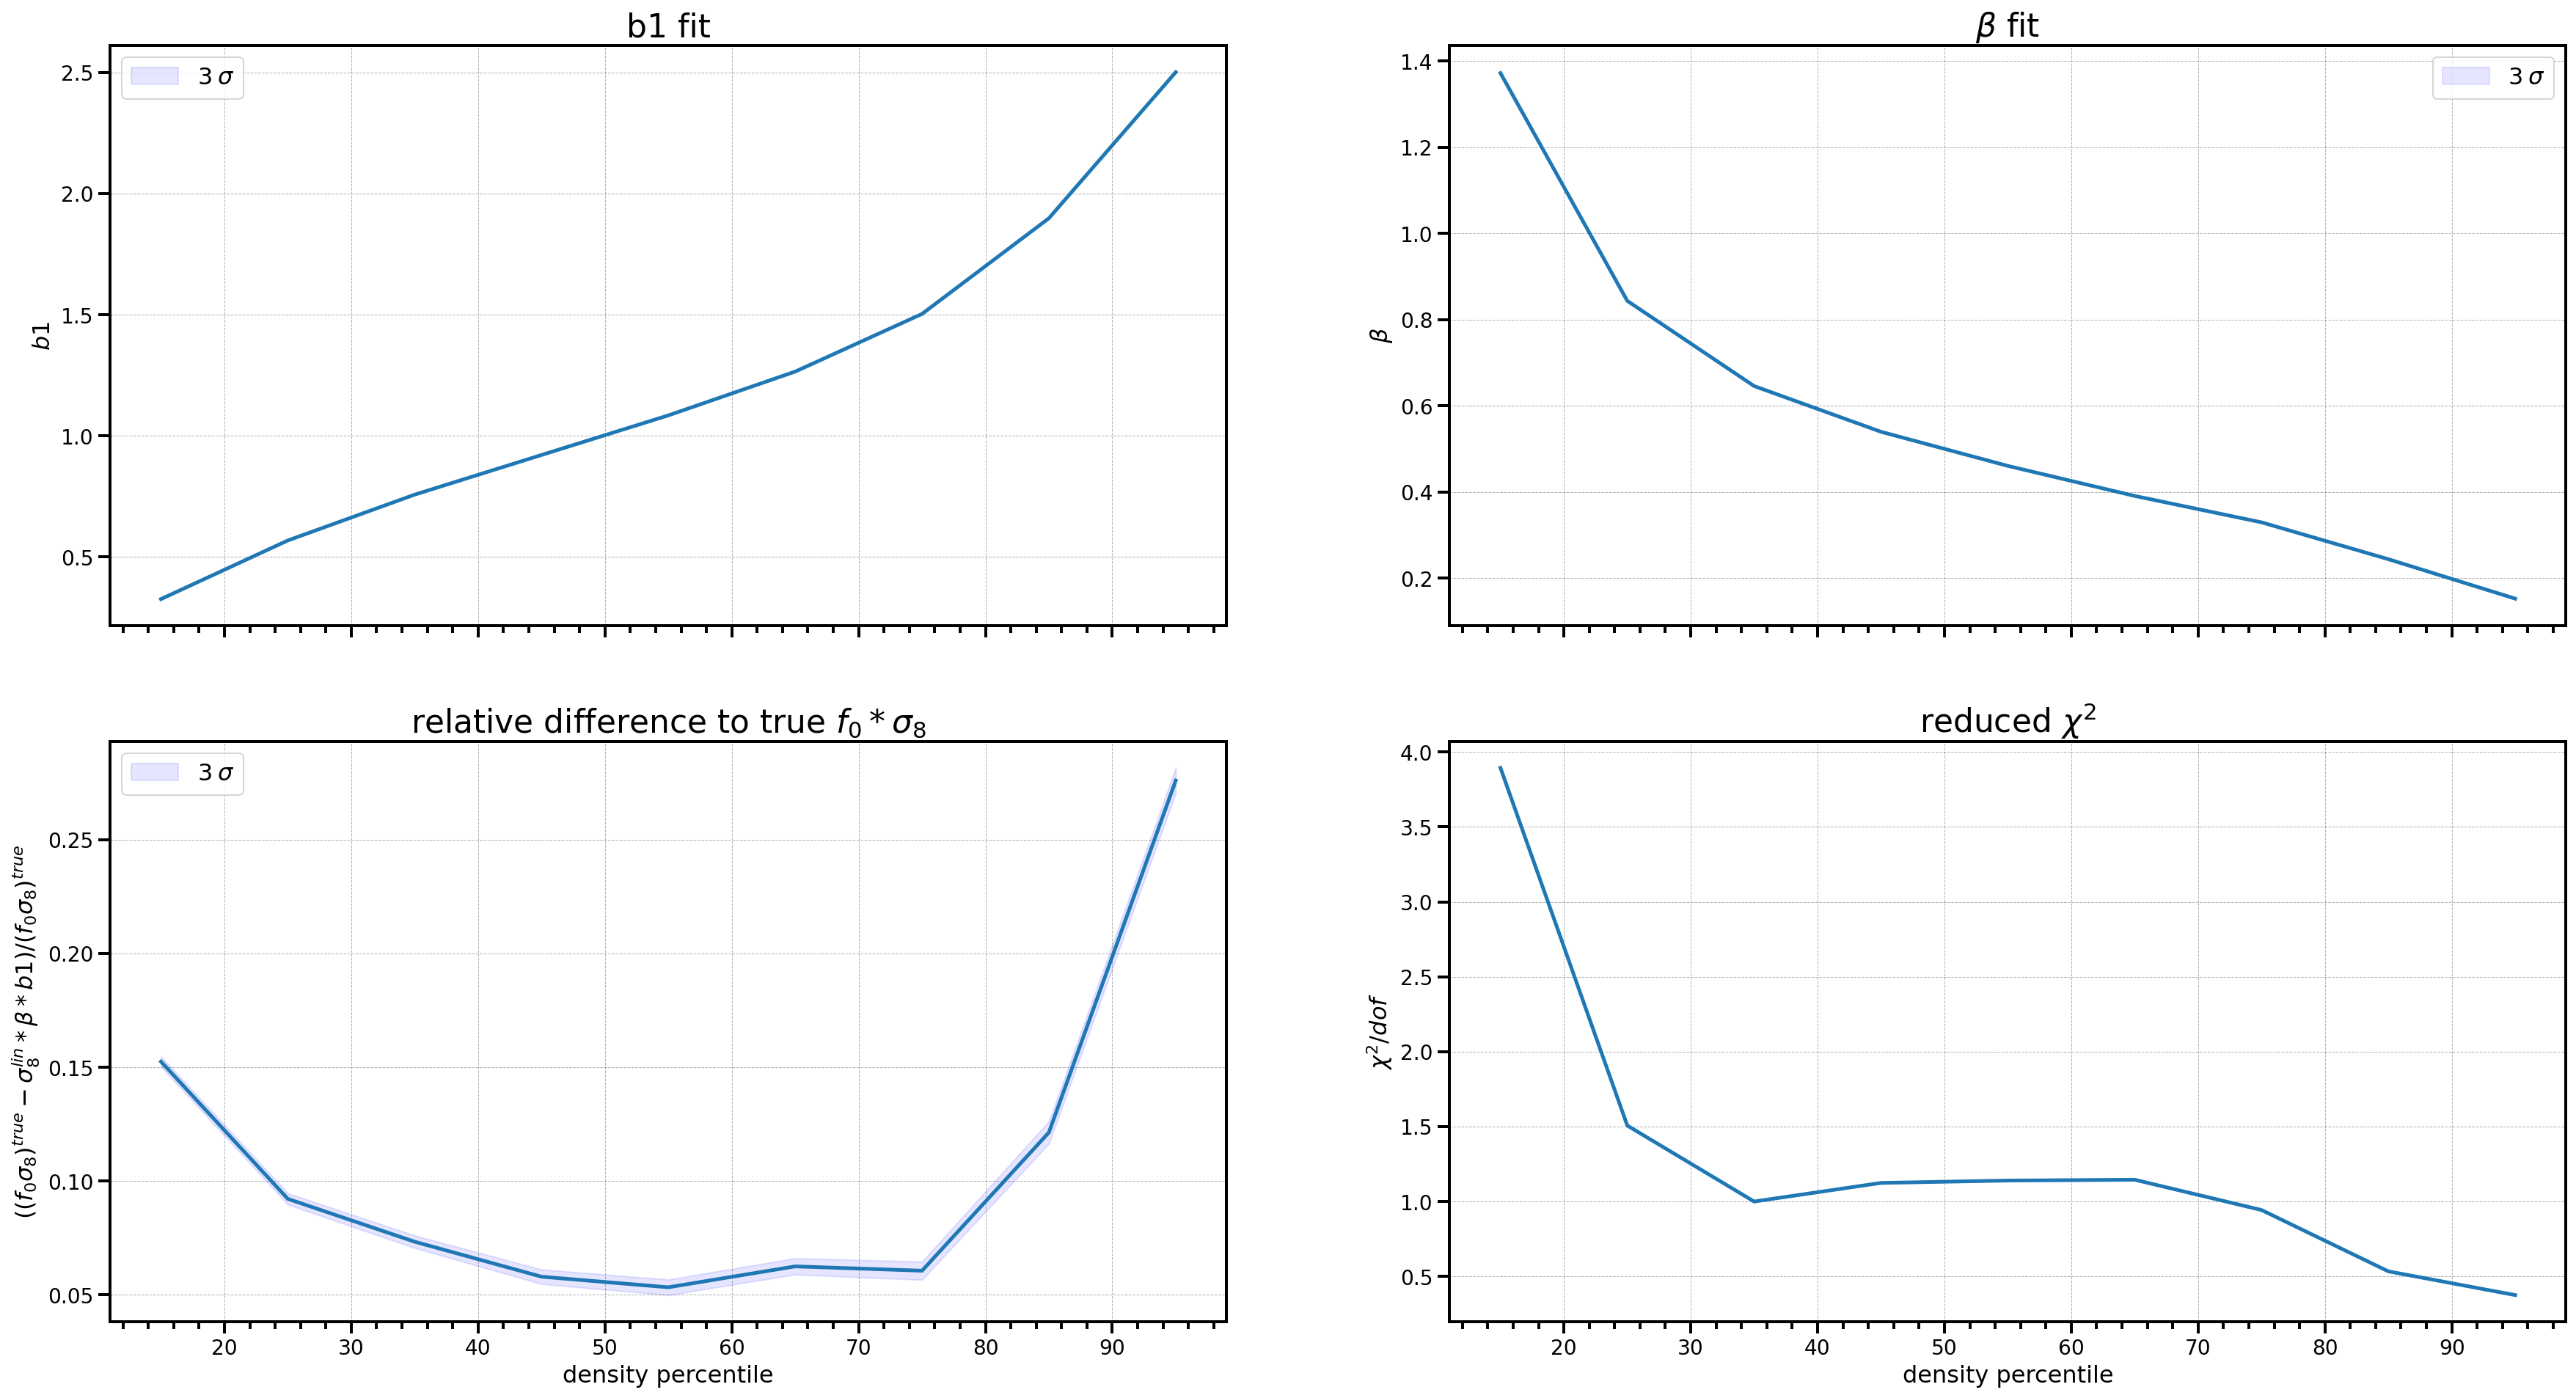

In [9]:
from matplotlib.ticker import AutoMinorLocator
fig, axs = plt.subplots(2, 2, figsize=(30,16), sharex=True)

mids = np.arange(5,105,10)[1:] # percentile mid points

axs[0][0].plot(mids, b1_fits[1:])
axs[0][0].fill_between(mids, b1_cred[:,0][1:], b1_cred[:,1][1:], color='b', alpha=0.1, label=r'$3 \: \sigma$')
axs[0][0].set_title("b1 fit")
axs[0][0].set_ylabel(r"$b1$")
axs[0][0].legend()

axs[0][1].plot(mids, beta_fits[1:])
axs[0][1].fill_between(mids, beta_cred[:,0][1:], beta_cred[:,1][1:], color='b', alpha=0.1, label=r'$3 \: \sigma$')
axs[0][1].set_title(r"$\beta$ fit")
axs[0][1].set_ylabel(r"$\beta$")
axs[0][1].legend()

delta_f0_sig8 = (f0_true*sigma8_true - sigma8_lin*(beta_fits*b1_fits)) / (f0_true*sigma8_true)
delta_f0_sig8_cred = (f0_true*sigma8_true - sigma8_lin*(beta_cred*b1_cred)) / (f0_true*sigma8_true)
axs[1][0].plot(mids, delta_f0_sig8[1:])
axs[1][0].fill_between(mids, delta_f0_sig8_cred[:,0][1:], delta_f0_sig8_cred[:,1][1:], color='b', alpha=0.1, label=r'$3 \: \sigma$')
axs[1][0].set_title(r"relative difference to true $f_0*\sigma_8$")
axs[1][0].set_xlabel("density percentile")
axs[1][0].set_ylabel(r"$((f_0\sigma_8)^{true} - \sigma_8^{lin}*\beta*b1)/(f_0\sigma_8)^{true}$")
axs[1][0].xaxis.set_minor_locator(AutoMinorLocator())
axs[1][0].legend()

axs[1][1].plot(mids, reduced_chi2[1:])
axs[1][1].set_title("reduced $\chi^2$")
axs[1][1].set_xlabel("density percentile")
axs[1][1].set_ylabel(r"$\chi^2 / dof$")
axs[1][1].xaxis.set_minor_locator(AutoMinorLocator())

plt.show()
#fig.savefig('plots/Fitting_b1_beta_densitybins_MCMC_mock.pdf')

### Interpretation
The ball park of the fitted parameter is similar to the one found in the fitting via minimizing chi2. The issue with the first percentile remains: The quadrupole moment is entirely negative such that a negative beta is fitted which gives a good chi2 but a wrong f0.

The estimated f0 is better in this fit is better compared to the one from minimizing chi2. There still is a tendency to underestimate f0. 

### Extra plots

- Make walker plots, showing value of $b1$ and $\beta$ over different steps along the chain for each walker
- Corner plot of posterior distributions. Values in header are dependent on what is passed as quantiles. By default `quantiles=[0.025, 0.5, 0.975]`, meaning that 2.5%, 50%, 97.5% of all values are to the left of the values in the header. 
    See https://zeus-mcmc.readthedocs.io/en/latest/api/plotting.html?highlight=cornerplot#zeus.cornerplot and https://github.com/minaskar/zeus/blob/76ae77de9f3218008dca9882ef7e16bd42405d1b/zeus/plotting.py#L177-L183.
    Also shows the smoothed 2D parameter distribution with contours corresponding to 0.5, 1, 1.5, and 2 sigma.

In [10]:
cur_chain = chains[4]

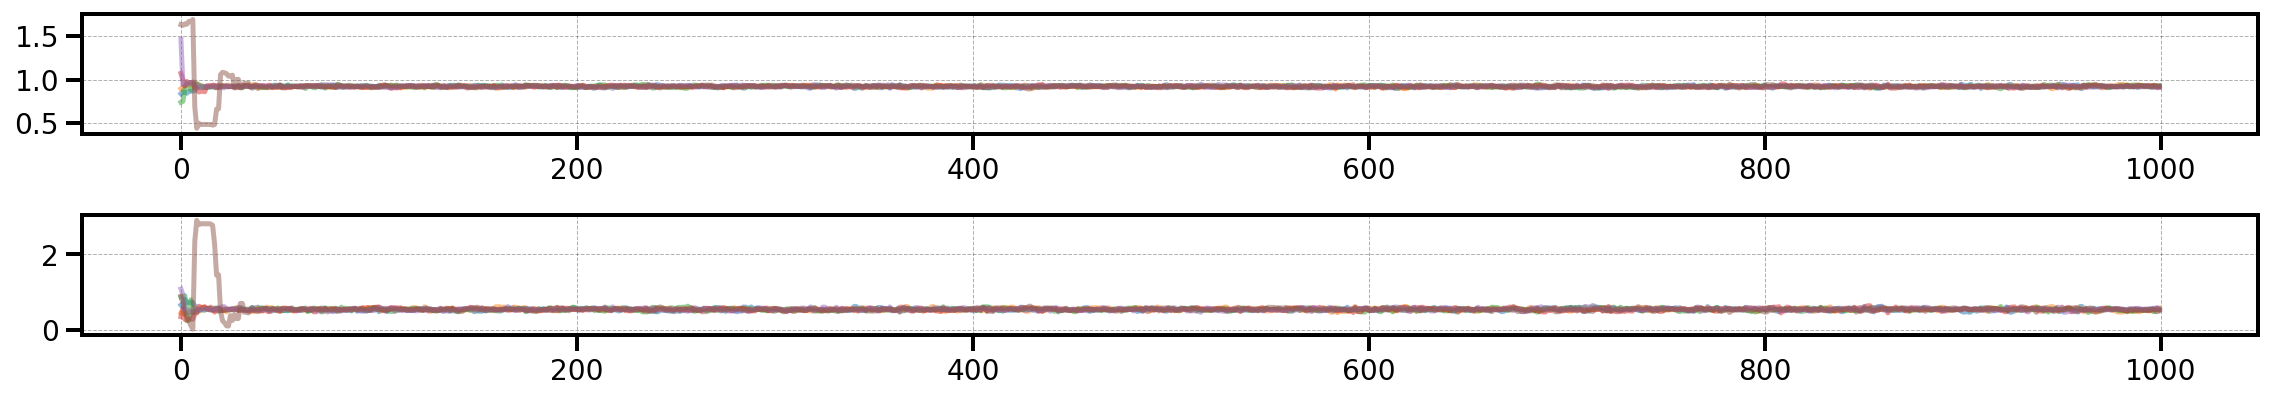

In [11]:
plt.figure(figsize=(16,1.5*ndim))
for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(cur_chain[:,:,n], alpha=0.5)
plt.tight_layout()
plt.show()

/home/jwack/.conda/envs/nbodykit-env/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/jwack/.conda/envs/nbodykit-env/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


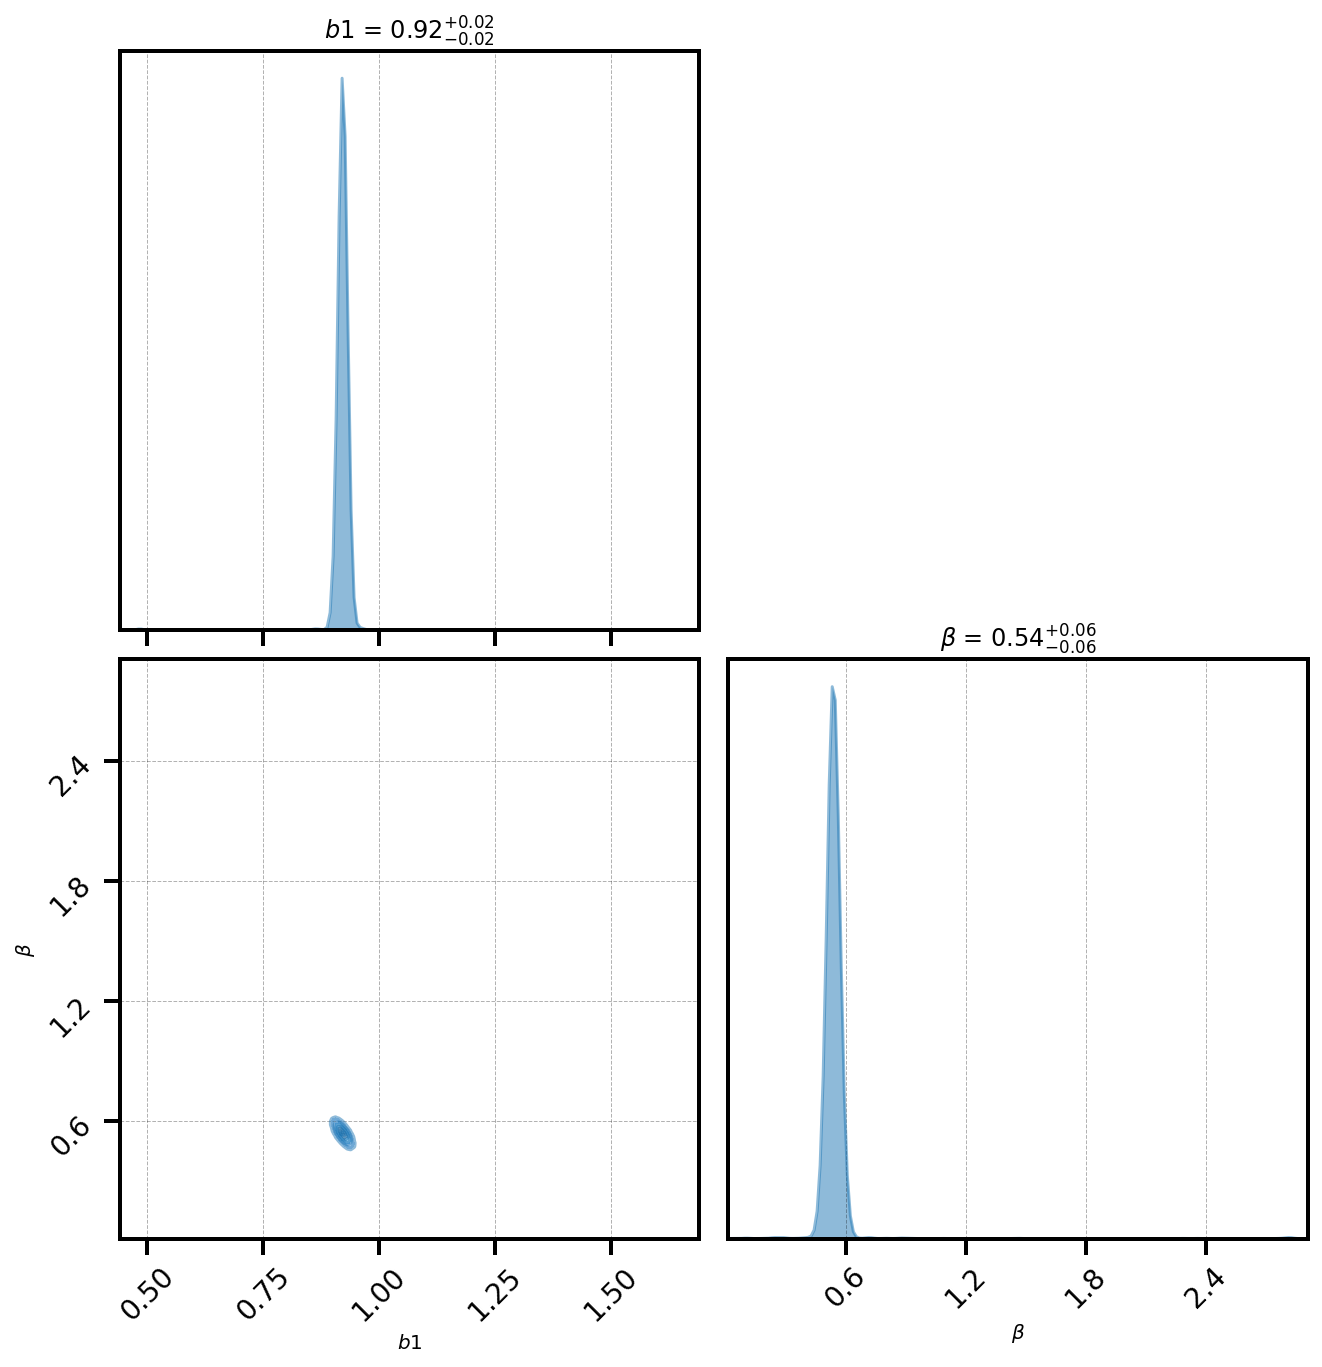

In [12]:
# Needs 'flattened' chain: (number walkers * number steps, ndim) i.e treats all walkers equally 
fig, axes = zeus.cornerplot(cur_chain.reshape((-1,ndim), order='F'), labels=[r'$b1$', r'$\beta$']);